### Disease balanced input data to RF (run2): analysis of classifier resutls

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve,average_precision_score,confusion_matrix,roc_auc_score,roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
os.chdir(os.getcwd())

In [30]:
best_params = np.load('../results/rf_gscv_best_params.npy').item()
depth = best_params['max_depth']
n_estimators = best_params['n_estimators']
min_samples_leaf = best_params['min_samples_leaf']
min_samples_split = best_params['min_samples_split']

best_params

{'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 100}

In [3]:
ribo_clinical = pd.read_csv("../data/TreehousePEDv9_Ribodeplete_clinical_metadata.2019-03-25.tsv", index_col=0, sep='\t')['disease']
poly_clinical = pd.read_csv("../data/clinical_TumorCompendium_v10_PolyA_2019-07-25.tsv", index_col=0, sep='\t')['disease']
all_clinical = pd.concat([ribo_clinical, poly_clinical], axis=0)

In [4]:
def fpr_tpr(mat):
    '''
    Function takes in a confusion matrix
    Retunr false positive rate (FPR) and true positive (TPR)
    
    Only works for binary cases
    '''
    tn, fp, fn, tp = mat.ravel()
    if len(mat.shape) !=2:
        raise ValueError('Function can only handle binary classification cases')
    tot = mat.sum(axis=1) # total negative(0) and positive(1) labels
    FPR = fp/tot[0]
    TPR = tp/tot[1]
        
    return FPR,TPR

In [5]:
# loading data: disease balanced data
X = pd.read_csv('../data/MergedData_Balanced.tsv', sep='\t', index_col=0)
Y = pd.read_csv('../data/MergedLabels_Balanced.tsv', sep='\t', index_col=0)

# splitting data into train and test
# data is split based on disease
# This means that disease prevalence is maintained in both train and test subsets
# This ensures reproducibility of the method
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=Y, random_state=42, test_size=0.3)

#loading random forest model with balanced params
model=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=depth, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                       min_weight_fraction_leaf=0.0, n_estimators=n_estimators,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


#fitting model to data
model.fit(X_train, Y_train.values.ravel())
pred = model.predict(X_test)
#scoring for accuracy
score = (model.score(X_test, Y_test.values.ravel()))

#getting probability scores for each sample
# probability scores for both classes (RiboD, PolyA) will sum to 1
y_proba = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(Y_test, y_proba)

# mean precision score
mean_precision = average_precision_score(Y_test, y_proba)
pred_proba = model.predict_proba(X_test)


res = {} # results dictionary to be used later for downstream analysis

res['test_labels'] = Y_test.values.ravel()
res['pred_labels'] = pred
res['pred_proba'] = pred_proba
res['acc'] = score
#res['oob_score'] = model.oob_score_
res['model'] = model
res['average_precision'] = mean_precision
res['precision'] = precision
res['recall'] = recall
res['genes'] = X.columns.tolist()
res['importances'] = model.feature_importances_
res['test_samples'] = X_test.index.values

#saving results
np.save('../results/RF_results_balanced.npy', res)
pickle.dump(model, open('../models/RiboVsPoly_balanced.sav', 'wb'))

In [6]:
X_train.shape

(316, 5000)

In [7]:
df = pd.DataFrame(np.hstack([pred.reshape(-1,1),pred_proba, Y_test.values]), columns=["Ribo", "Proba_Poly", "Proba_Ribo", "TrueLabel"], index=X_test.index)

Logistic: ROC AUC=0.989


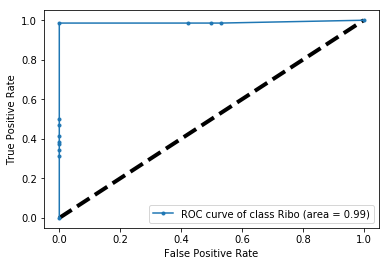

In [8]:
# predict probabilities
# keep probabilities for the positive outcome only
rf_probs = df.Proba_Ribo.values
# calculate scores
rf_auc = roc_auc_score(Y_test, rf_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(Y_test, rf_probs)
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.plot(rf_fpr, rf_tpr, marker='.',
label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format('Ribo', rf_auc))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [9]:
# load results
results = np.load('../results/RF_results_balanced.npy', allow_pickle=True).item()

In [10]:
results.keys()

dict_keys(['pred_proba', 'average_precision', 'recall', 'acc', 'precision', 'model', 'pred_labels', 'genes', 'test_samples', 'test_labels', 'importances'])

In [11]:
print('Accuracy achieved: %.3f'%results['acc'])

Accuracy achieved: 0.963


In [12]:
print('Average precision achieved: %.3f'%results['average_precision'])

Average precision achieved: 0.993


In [13]:
mismatch = results['test_labels'] != results['pred_labels']
mismatch_idx = [i for i,e in enumerate(mismatch) if e ]

In [14]:
misclassified_df = pd.DataFrame(results['pred_proba'][mismatch_idx], index=results['test_samples'][mismatch_idx], columns=['PolyA', 'Ribo'])


### List of miscalssified samples

In [15]:
misclassified_df

,PolyA,Ribo
THR21_0559_S01,0.999873,0.000127
THR33_0990_S01,0.212635,0.787365
THR37_1306_S01,0.438480,0.561520
THR37_1308_S01,0.335965,0.664035
THR20_0519_S01,0.234584,0.765416


In [16]:
all_clinical.loc[misclassified_df.index]

THR21_0559_S01    glioblastoma multiforme
THR33_0990_S01            medulloblastoma
THR37_1306_S01                 ependymoma
THR37_1308_S01                 ependymoma
THR20_0519_S01            medulloblastoma
Name: disease, dtype: object

In [17]:
mat = confusion_matrix(results['test_labels'], results['pred_labels'])

### Confusion matrix shows good separation between the two calsses
* **Class 0**: PolyA libraries
* **Class 1**: Ribo-deplete libraries
* 4 PolyA samples misclassified as Ribo-deplete
* 1 RiboD sample misclassified as PolyA

Text(0.5, 15.0, 'Predicted Label')

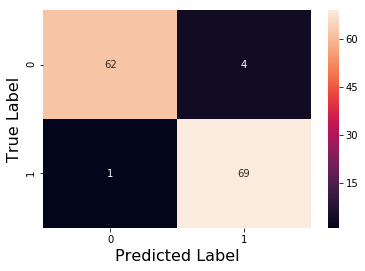

In [18]:
ax = sns.heatmap(mat, annot=True)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)


In [19]:
fpr, tpr = fpr_tpr(mat)
print('FPR = {:.3f}, TPR = {:.3f}'.format(fpr, tpr))

FPR = 0.061, TPR = 0.986


In [20]:
importances = zip(results['importances'], results['genes'])

In [21]:
importances = sorted(importances, key = lambda x:x[0], reverse=True)


In [22]:
scores = list(map(lambda x:x[0], importances))
genes = list(map(lambda x:x[1], importances))

### Gene importance determined by RF classifier

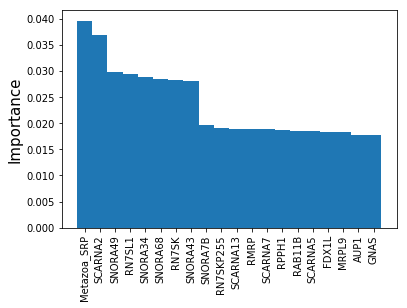

In [23]:
plt.bar(np.arange(len(scores[:20])), scores[:20], width=1)
plt.xticks(labels=genes[:20], ticks=np.arange(len(scores[:20])), rotation=90)
plt.ylabel("Importance", fontsize=15)
plt.show()
plt.close()

In [ ]:
with open('../results/RF_gene_rank_balanced.tsv', 'w') as f:
    f.write('Gene\tScore\n')
    for i in range(len(scores)):
        score = scores[i]
        gene = genes[i]
        f.write(gene+'\t'+str(score)+'\n')
        
    

### Attempting to improve probability threshold

Text(0.5, 1.0, 'Probability of being Ribo')

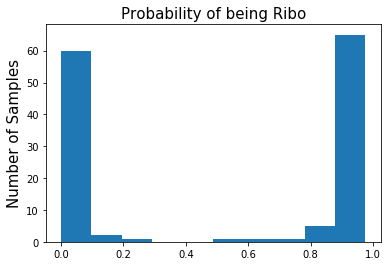

In [24]:
plt.hist(results['pred_proba'][:,1])
plt.ylabel("Number of Samples", fontsize=15)
plt.title('Probability of being Ribo', fontsize=15)

<Figure size 720x720 with 0 Axes>

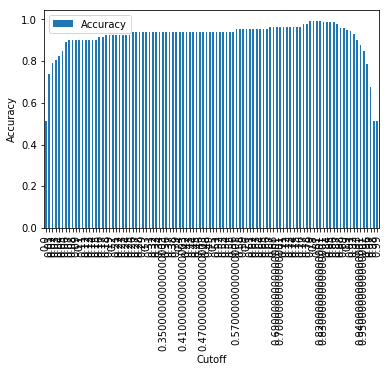

Best cutoff: 0.79
Best accuracy: 0.9930672268907563


Text(0.5, 15.0, 'Predicted Label')

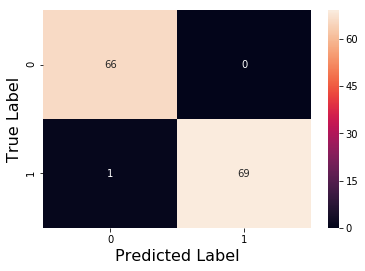

In [25]:
accuracy_df=pd.DataFrame()
best_score=None
best_cutoff=None
best_pred=None
for cutoff in np.arange(0,1,0.01):

    test_pred_classes=[]
    for i in results['pred_proba'][:,1]:
        if i>=cutoff:
            test_pred_classes+=[1]
        else:
            test_pred_classes+=[0]
            
    score=average_precision_score(results['test_labels'],test_pred_classes )
    accuracy_df.loc[cutoff, 'Accuracy']=score
    #storing predictions with best accuracy score
    if best_score is None or score>best_score:
        best_score=score
        best_cutoff=cutoff
        best_pred=test_pred_classes


plt.figure(figsize=(10,10))
accuracy_df.plot(kind='bar')
plt.xlabel('Cutoff')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

plt.show()
plt.close()
print('Best cutoff: {}'.format(best_cutoff))
print('Best accuracy: {}'.format(best_score))

# print(accuracy_df.describe())

mat_2 = confusion_matrix(results['test_labels'], best_pred)
ax2 =sns.heatmap(mat_2, annot=True)
ax2.set_ylabel("True Label", fontsize=16)
ax2.set_xlabel("Predicted Label", fontsize=16)

In [26]:
fpr, tpr = fpr_tpr(mat_2)
print('FPR = {:.3f}, TPR = {:.3f}'.format(fpr, tpr))

FPR = 0.000, TPR = 0.986


# Applying on rest of PolyA not used in training

In [29]:
poly_reduced = pd.read_csv("../data/Poly_reduced.tsv", sep='\t', index_col=0)
poly = pd.read_csv("../data/TumorCompendium_v10_PolyA_hugo_log2tpm_58581genes_2019-07-25.tsv", sep='\t', index_col=0)
poly = poly.loc[poly_reduced.columns.tolist()].T #selecting teh top 5k genes
poly_rest = poly.loc[list(set(poly.index).difference(poly_reduced.index))]

In [31]:
poly.shape

(12236, 5000)

In [32]:
poly_rest_pred = model.predict(poly_rest)
poly_rest_proba = model.predict_proba(poly_rest)

In [33]:
#pd.DataFrame(np.hstack([poly_rest_pred.reshape(-1,1),poly_rest_proba]), columns=["Ribo", "Proba_Poly", "Proba_Ribo"], index=poly_rest.index).to_csv("PolyRestBalancedResults.tsv", sep='\t')

In [34]:
(poly_rest_pred==0).sum()/poly_rest.shape[0]

0.9900133155792277

In [35]:
(poly_rest_pred==1).sum()

120